# Create and deploy a custom model

This accelerator outlines how to create, deploy, and monitor a custom inference model with DataRobot's Python client. You can use the Custom Model Workshop to upload a model artifact to create, test, and deploy custom inference models to DataRobot’s centralized deployment hub.

## Setup

### Install libraries

Before running this notebook make sure you have the libraries needed to support this model. 

Install the following repositories and Python packages: 

```
pip install datarobot-drum
pip install datarobot
pip install 'xgboost==2.0.0' 'pyyaml==5.3.1'
```
Make a directory to hold the custom model. 

```
mkdir custom_model_xgboost
```

### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [2]:
import datarobot as dr

dr_client = dr.Client()

## Train a custom XGBoost model

Provide modeling training data to train a custom XGBoost model with the scikit-learn pipeline in a binary classification use case.

Install the required Python modules (`PyYAML==5.3.1` and `xgboost==1.2.1`) using the requirements file.

In [1]:
from io import StringIO
import json
import pickle

import numpy as np
import pandas as pd
import requests as r
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier

Use the following cells to build a Scikit-Learn Regression model (XGBoost) to predict if a loan will default or not.

In [3]:
with StringIO() as str_io:
    resp = r.get("https://s3.amazonaws.com/datarobot_public_datasets/10K_Lending_Club_Loans.csv")
    str_io.write(resp.text)
    str_io.seek(0)
    train = pd.read_csv(str_io)
X = train.drop("is_bad", axis=1)
y = train.pop("is_bad")
train.head(5)

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mths_since_last_major_derog,policy_code
0,4000,4000,60 months,7.29%,79.76,A,A4,Time Warner Cable,10+ years,MORTGAGE,...,NaN,NaN,15.0,0.0,12087,12.1,44.0,f,NaN,1
1,16000,16000,60 months,18.25%,408.48,F,F1,Ottawa University,< 1 year,RENT,...,NaN,NaN,4.0,0.0,10114,64.0,5.0,f,NaN,1
2,8700,8700,36 months,7.88%,272.15,A,A5,Kennedy Wilson,4 years,RENT,...,NaN,NaN,4.0,0.0,81,0.6,8.0,f,NaN,1
3,18000,18000,60 months,11.49%,395.78,B,B4,TOWN OF PLATTEKILL,10+ years,MORTGAGE,...,16.0,NaN,6.0,0.0,10030,37.1,23.0,f,NaN,1
4,16000,16000,36 months,11.83%,530.15,B,B3,Belmont Correctional,10+ years,MORTGAGE,...,NaN,NaN,8.0,0.0,10740,40.4,21.0,f,NaN,1


Define and fit the preprocessing step per type of feature column.

In [17]:
# Preprocessing for numerical features
numeric_features = list(X.select_dtypes("int64").columns)
for c in numeric_features:
    X[c] = X[c].fillna(0)
numeric_transformer = Pipeline(
    steps=[
        ("imputeration_numeric", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

# Preprocessing for categorical features
categorical_features = list(X.select_dtypes("object").columns)
categorical_transformer = Pipeline(
    steps=[
        (
            "imputeration_numeric",
            SimpleImputer(strategy="constant", fill_value="_missing"),
        ),
        ("OneHotEncoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Preprocessor with all of the steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

model = XGBClassifier(
    colsample_bylevel=0.2,
    max_depth=10,
    learning_rate=0.02,
    n_estimators=300,
    eval_metric="logloss",
)

# Full modeling pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("xgboost model", model)])

# Train the model-Pipeline
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputeration_numeric',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Id', 'revol_bal',
                                                   'mths_since_last_major_derog']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputeration_numeric',
                                                                   SimpleImputer(fill_value='_missing',
                                                                                 strategy='constant')),
                                          

Finally, train an XGBoost Classifier and save both the custom model and preprocessing pipeline in pickle files. Then use these pickle files to upload them in DataRobot.

In [18]:
with open("custom_model_xgboost/model.pkl", "wb") as pklfile:
    pickle.dump(pipeline, pklfile)

## Test custom models locally

Before uploading custom models to DataRobot, DataRobot recommends testing models locally using DRUM (the DataRobot custom model runner tool). DRUM verifies that a custom model can successfully run and make predictions. Note that this testing is only for development purposes, so you will also need to test the custom inference models in the Custom Model Workshop after uploading the custom model to the DataRobot platform.

Now, use DRUM to test how the model performs by computing latency times and memory usage for several different test case sizes. A report is generated after this process is completed. View a sample output below.

In [11]:
!drum perf-test --code-dir ./custom_model_xgboost --input ./datarobot-user-models/tests/testdata/lending_club_reduced.csv --target-type binary --positive-class-label '1' --negative-class-label '0'

DRUM performance test
Model:      /Users/luke.shulman/Projects/custom-model-notebook-testing/custom_model_xgboost
Data:       /Users/luke.shulman/Projects/custom-model-notebook-testing/datarobot-user-models/tests/testdata/lending_club_reduced.csv
# Features: 24
Preparing test data...



Running test case with timeout: 600
Running test case: 108 bytes - 1 samples, 100 iterations
Running test case with timeout: 600
Running test case: 0.1MB - 969 samples, 50 iterations
Processing |################################| 50/50
Running test case with timeout: 600
Running test case: 10MB - 96950 samples, 5 iterations
Processing |################################| 5/5
Running test case with timeout: 600
Running test case: 50MB - 484753 samples, 1 iterations
Processing |################################| 1/1
Test is done, stopping drum server
>78
  size     samples   iters    min     avg     max     total     used     total p
                                                       (s)      (MB)     

DRUM can also validate models to detect and address issues before uploading to DataRobot. Locally, DRUM runs the same tests DataRobot runs automatically before deploying models. Specifically, it tests models for the ability to impute null values, setting each feature in the dataset to "missing" and then sending the features to the model. The two code snippets below validate a model and send the results to `validation.log` and then copy the outcome.

In [19]:
!drum validation --code-dir ./custom_model_xgboost --input ./datarobot-user-models/tests/testdata/lending_club_reduced.csv --target-type binary --positive-class-label '1' --negative-class-label '0' > validation.log

In [20]:
!cat validation.log



Validation checks results
      Test case          Status   Details
Basic batch prediction   PASSED          
Null value imputation    PASSED          


Finally, you can use the model to make predictions. To do this, leverage DRUM and its ability to natively handle the Scikit-Learn model. You need to specify where the model resides and what data to score.

In [21]:
!drum score --code-dir ./custom_model_xgboost --input ./datarobot-user-models/tests/testdata/lending_club_reduced.csv --target-type binary --positive-class-label '1' --negative-class-label '0' > predictions.csv

In [22]:
pd.read_csv("predictions.csv").head()

,0 1
0,0 0.942158 0.057842
1,1 0.930368 0.069632
2,2 0.926166 0.073834
3,3 0.940501 0.059499
4,4 0.938420 0.061580


## Upload custom model artifacts to DataRobot

After testing the custom model locally, upload all the artifacts to DataRobot. To upload the custom model artifacts, you must import several additional packages.

In [24]:
import datetime as dt
from datetime import datetime
from importlib import reload
import os
import re

import datarobot as dr
from datarobot import Deployment, Project
import dateutil.parser

First we will add a requirements file to our custom model directory to make sure, the same version of XGBoost is used. 

In [29]:
%%writefile custom_model_xgboost/requirements.txt
xgboost==2.0.0


Writing custom_model_xgboost/requirements.txt


### Select an environment

Select an [environment](https://docs.datarobot.com/en/docs/mlops/deployment/custom-models/custom-env.html) to run the custom inference model. Instead of creating your own environment, select a pre-built environment provided by DataRobot and modify it to add the required packages and dependencies.

In [31]:
# List all existing base environments
execution_environments = dr.ExecutionEnvironment.list()
execution_environments

for execution_environment in execution_environments:
    # print(execution_environment)
    if execution_environment.name == "[DataRobot] Python 3.9 XGBoost Drop-In":
        BASE_ENVIRONMENT = execution_environment
        environment_versions = dr.ExecutionEnvironmentVersion.list(execution_environment.id)
        break

BASE_ENVIRONMENT_VERSION = environment_versions[0]

print(BASE_ENVIRONMENT)
print(BASE_ENVIRONMENT_VERSION)
print(BASE_ENVIRONMENT.id)

ExecutionEnvironment('[DataRobot] Python 3.9 XGBoost Drop-In')
ExecutionEnvironmentVersion('v51')
5e8c88a407389fe0f466c72f


## Upload datasets for custom model testing and training evaluation

In [ ]:
df = pd.read_csv("./datarobot-user-models/tests/testdata/lending_club_reduced.csv")
df_inference = pd.read_csv(
    "./datarobot-user-models/tests/testdata/lending_club_reduced.csv"
).sample(25)

train_dataset = dr.Dataset.create_from_in_memory_data(df, categories=["TRAINING"])
pred_test_dataset = dr.Dataset.create_from_in_memory_data(df_inference)

### Create a model package

Next, create a custom model package. To do so, complete three tasks:

1. Add a new, "empty" custom inference model package. 
2. Add artifacts to assemble the custom inference model. 
3. Update and modify the pre-built environment you previously selected.

The code for each of these tasks is outlined in the following cell:

In [38]:
# Create a new custom model
custom_model = dr.CustomInferenceModel.create(
    name="Loan Default Custom - 2023-10-11 - API Python",
    target_type=dr.TARGET_TYPE.BINARY,
    target_name="is_bad",
    positive_class_label="1",
    negative_class_label="0",
    description="XGboost model. Preprocess data using scikit-learn pipeline",
    language="Python",
    is_training_data_for_versions_permanently_enabled=True,  # for latest updates to Model Registry in 9.0
)

# Create a new custom model version in DataRobot
print("Upload new version of model to DataRobot")
model_version = dr.CustomModelVersion.create_clean(
    custom_model_id=custom_model.id,
    base_environment_id=BASE_ENVIRONMENT.id,
    files=[
        "./custom_model_xgboost/model.pkl",
        "./custom_model_xgboost/requirements.txt",
    ],
    training_dataset_id=train_dataset.id,
)


build_info = dr.CustomModelVersionDependencyBuild.start_build(
    custom_model_id=custom_model.id,
    custom_model_version_id=model_version.id,
    max_wait=3600,  # set a long timeout
)

Upload new version of model to DataRobot


## Test the custom inference model in DataRobot

Next, use the environment to run the model with prediction test data to verify that the custom model is functional before deployment. To do this, upload the inference dataset for testing predictions.

After uploading the inference dataset, you can test the custom inference model. View a sample outcome of testing below.

In [39]:
# Test a new version in DataRobot
print("Run test of new version in DataRobot")
custom_model_test = dr.CustomModelTest.create(
    custom_model_id=custom_model.id,
    custom_model_version_id=model_version.id,
    dataset_id=pred_test_dataset.id,
    max_wait=3600,  # 1 hour timeout
)
custom_model_test.overall_status

# Option 1
HOST = "https://app.datarobot.com"
for name, test in custom_model_test.detailed_status.items():
    print("Test: {}".format(name))
    print("Status: {}".format(test["status"]))
    print("Message: {}".format(test["message"]))

print("Finished testing: " + HOST + "model-registry/custom-models/" + custom_model.id + "/assemble")

Run test of new version in DataRobot
Test: error_check
Status: succeeded
Message: 
Test: null_value_imputation
Status: succeeded
Message: 
Test: long_running_service
Status: succeeded
Message: 
Test: side_effects
Status: succeeded
Message: 
Test: prediction_verification_check
Status: skipped
Message: 
Test: performance_check
Status: skipped
Message: 
Test: stability_check
Status: skipped
Message: 
Finished testing: https://app.datarobot.commodel-registry/custom-models/653721b0b0b9ef3dfa210eb2/assemble


## Create a model package and compliance documentation

The following snippet uses the REST API to create a model package in the custom model registry. This model package will then generate compliance documentation on the model.

In [41]:
register_model_package_endpoint = "modelPackages/fromCustomModelVersion/"

request_body = {
    "customModelVersionId": model_version.id,
}
package = dr_client.post(register_model_package_endpoint, request_body).json()

In [ ]:
html_doc = dr.AutomatedDocument(
    document_type="MODEL_COMPLIANCE", output_format="html", entity_id=package["id"]
)


html_doc.filepath = "test.html"
initalization_job = html_doc.initialize_model_compliance()

In [ ]:
initlization_job

In [51]:
html_run_job = html_doc.generate(max_wait=3600)  # this can take a little while

Feature Name,Var Type,Unique,Missing,Mean,Std Dev,Median,Min,Max,Target Leakage
Id,Numeric,10000,0,5000.5,2886.75,5000.5,1.0,10000.0,N/A
is_bad,Numeric,2,0,0.13,0.34,0.0,0.0,1.0,N/A
emp_length,Numeric,13,250,4.99,3.45,4.0,1.0,33.0,Low
home_ownership,Categorical,5,0,N/A,N/A,N/A,N/A,N/A,Low
annual_inc,Numeric,1901,1,68203.012,48587.82,58000.0,2000.0,900000.0,Low
verification_status,Categorical,3,0,N/A,N/A,N/A,N/A,N/A,Low
pymnt_plan,Categorical,2,0,N/A,N/A,N/A,N/A,N/A,N/A
purpose_cat,Categorical,27,0,N/A,N/A,N/A,N/A,N/A,Low
zip_code,Categorical,720,0,N/A,N/A,N/A,N/A,N/A,Low
addr_state,Categorical,50,0,N/A,N/A,N/A,N/A,N/A,Low

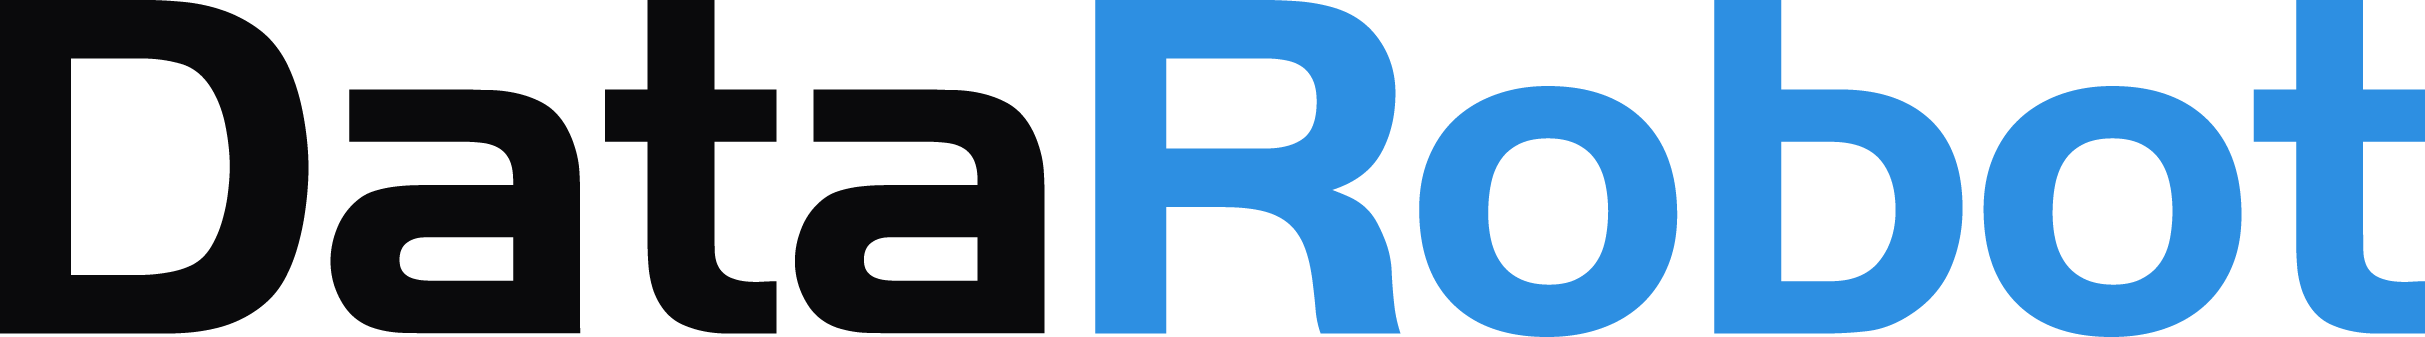
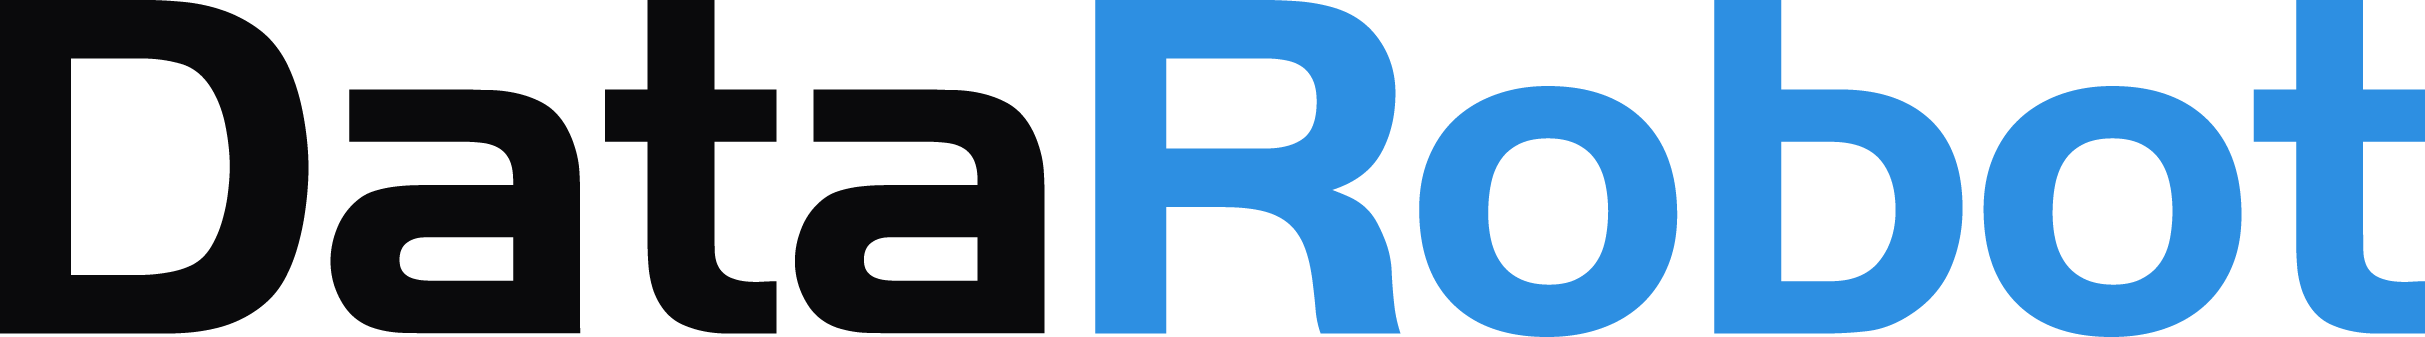
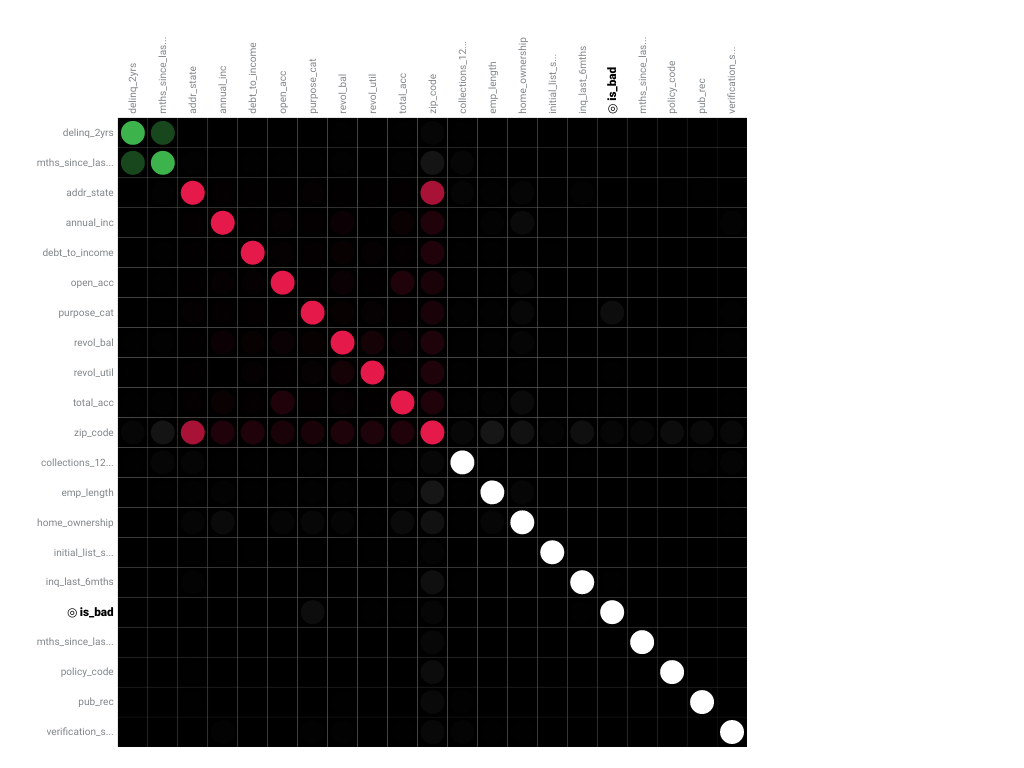
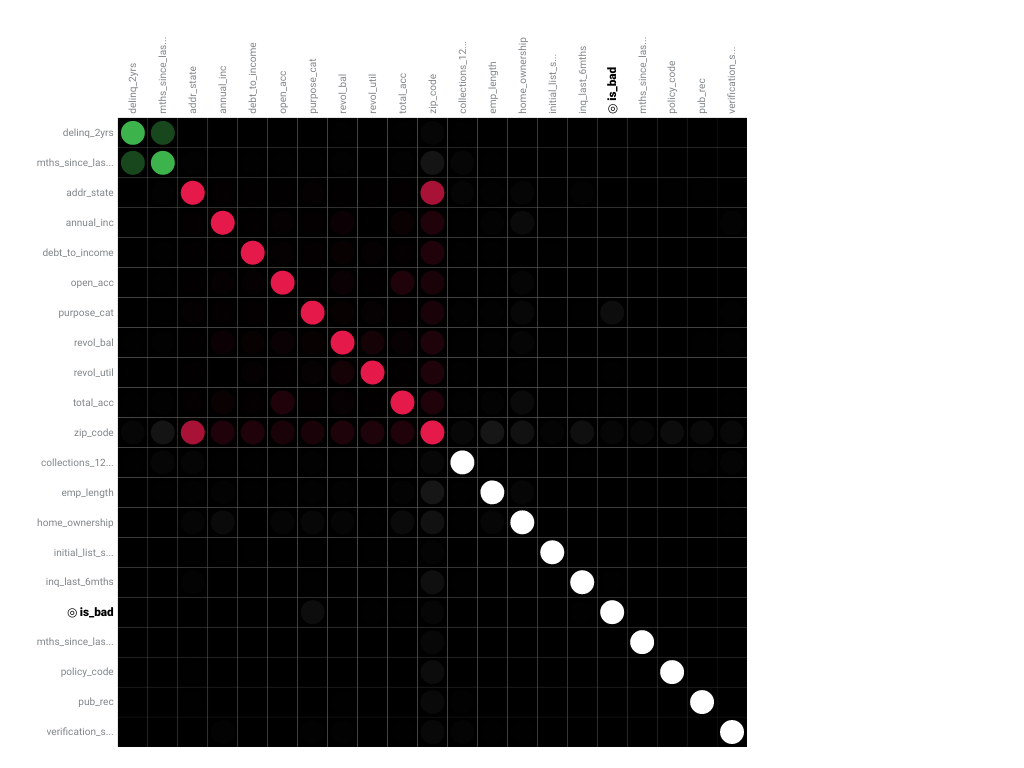
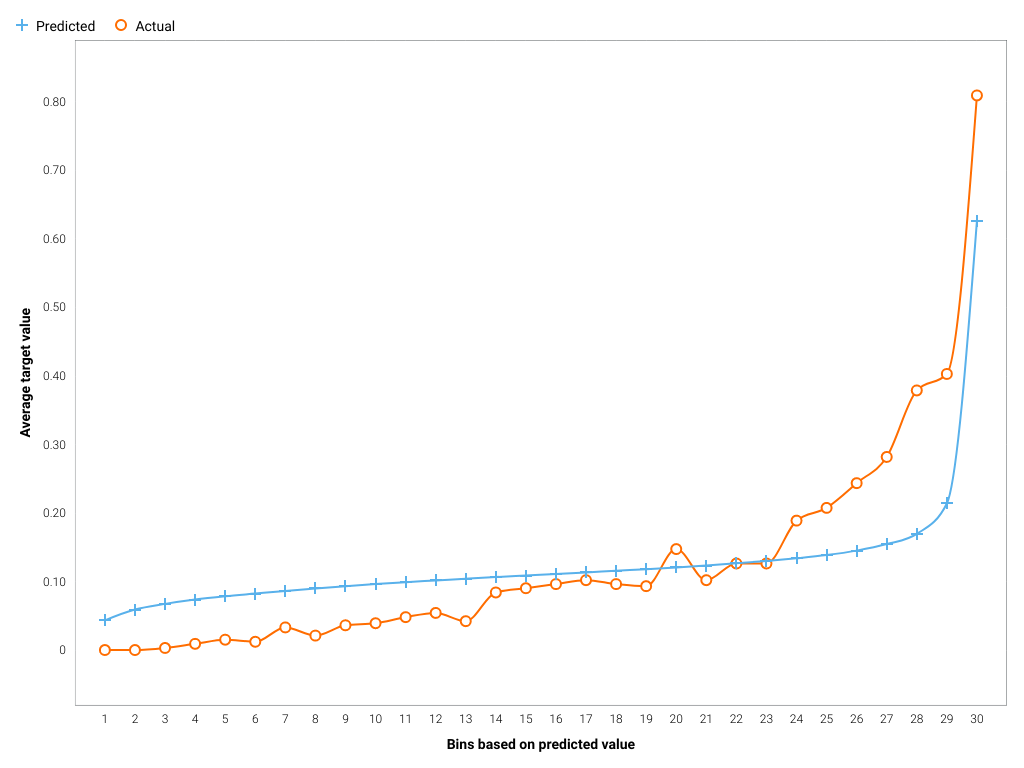
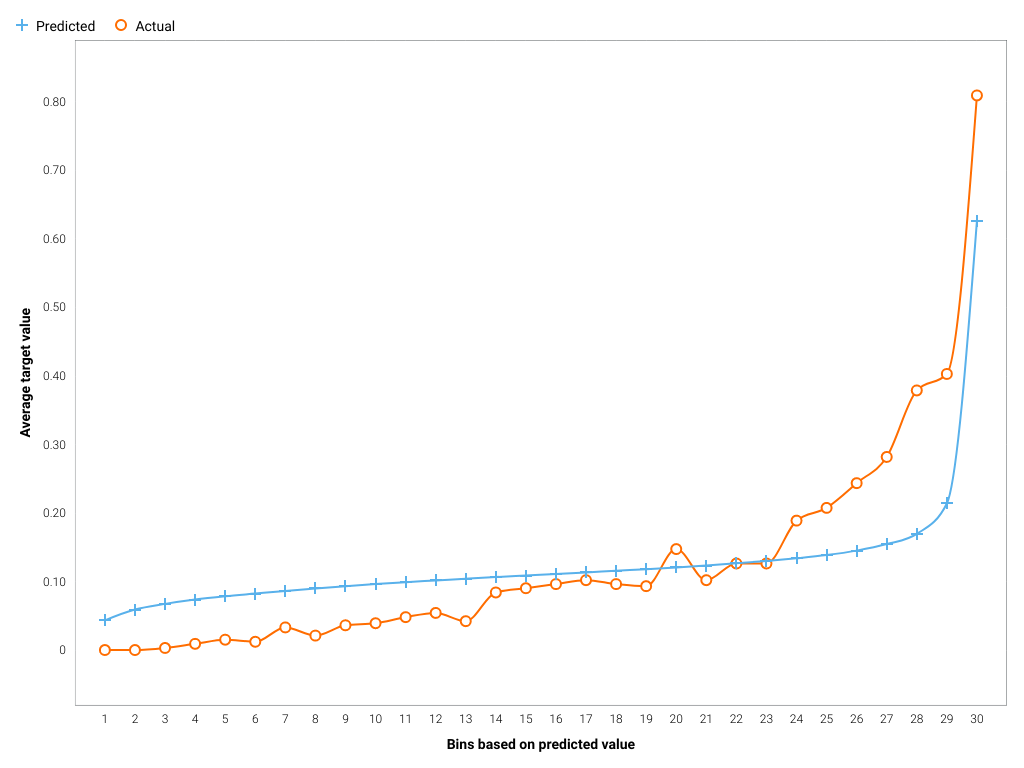
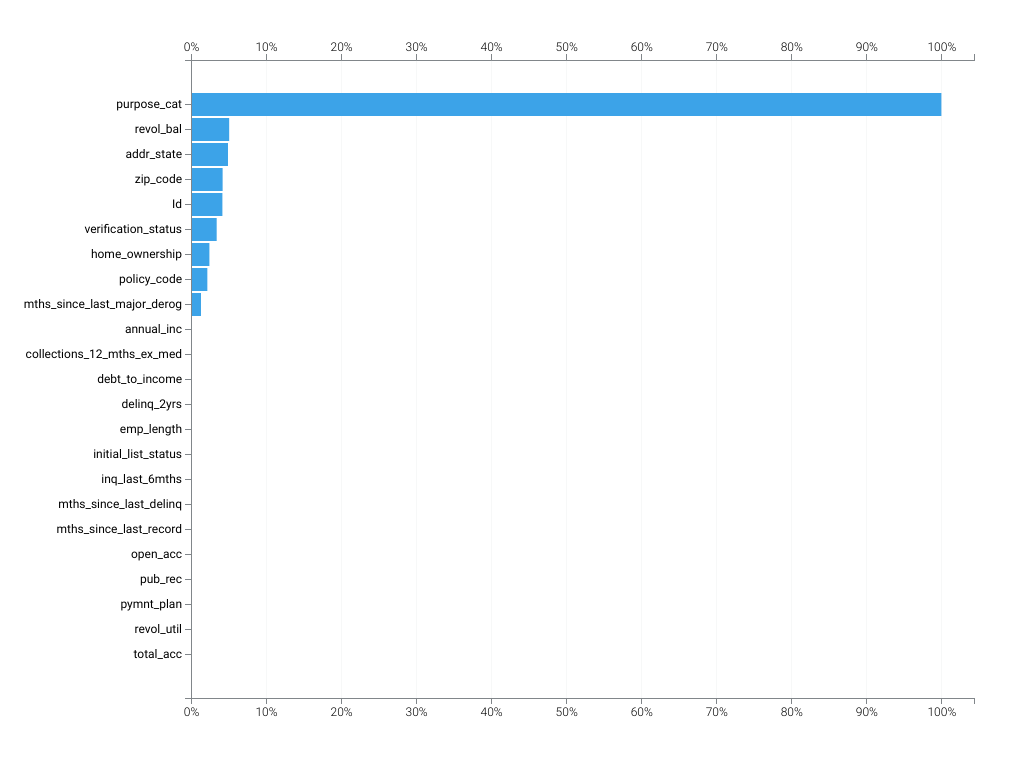
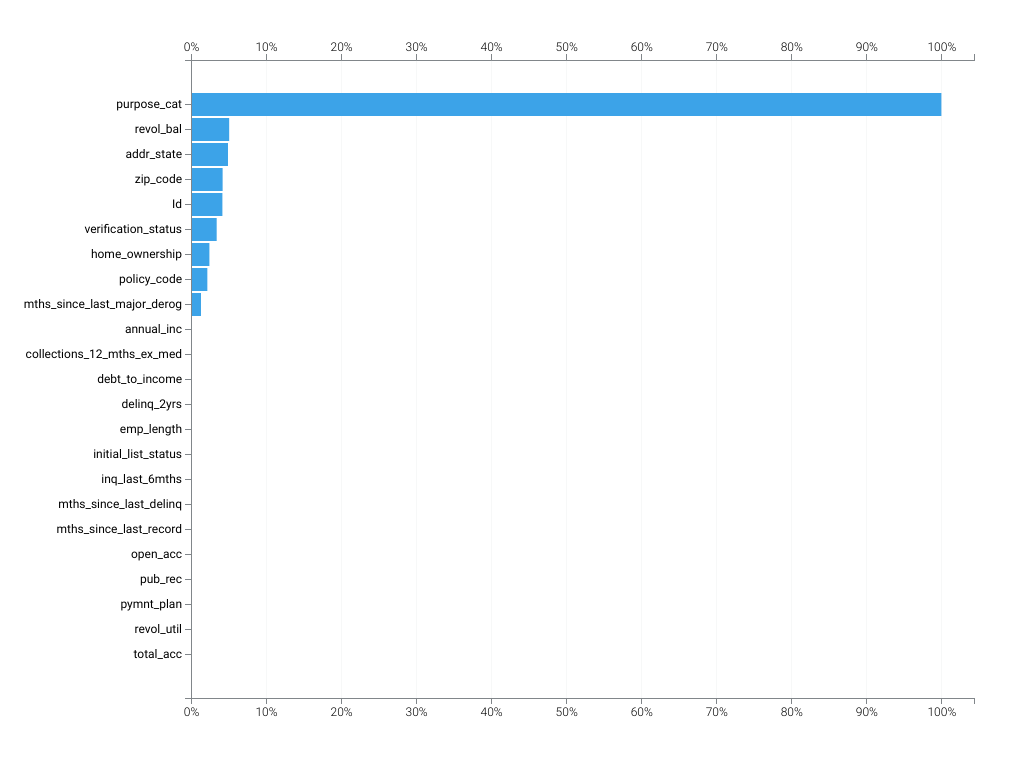
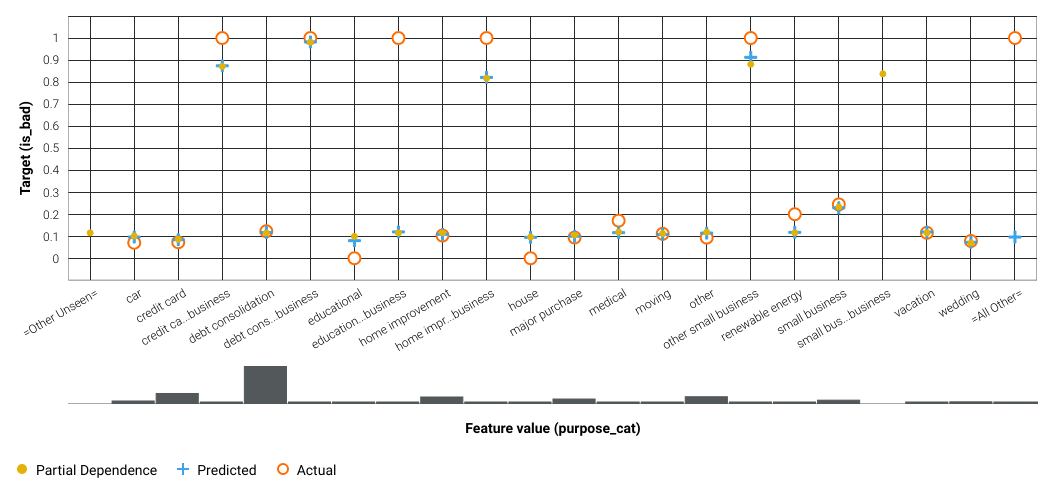
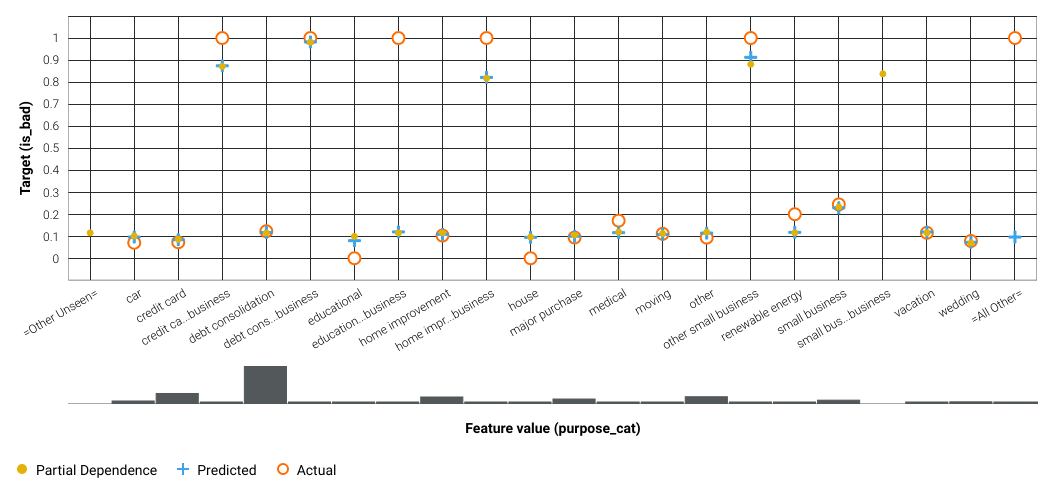
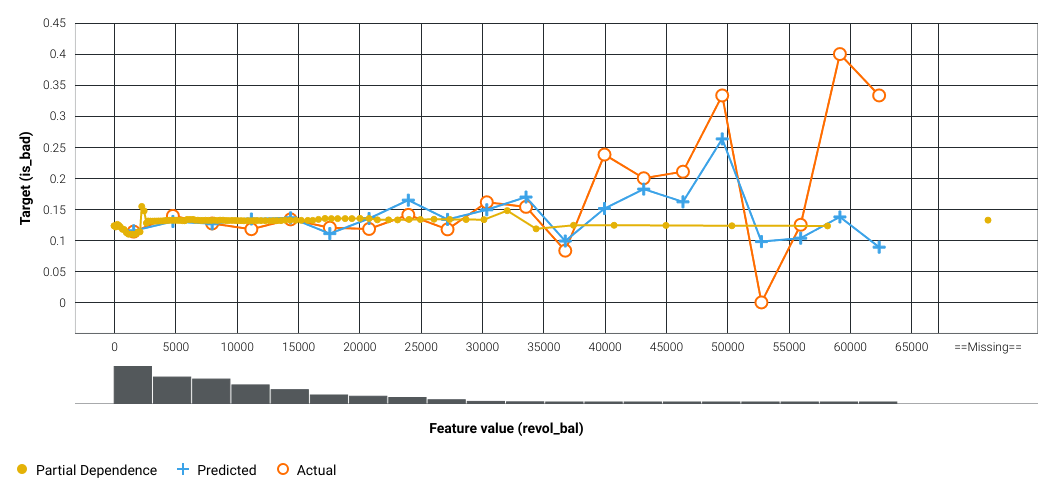
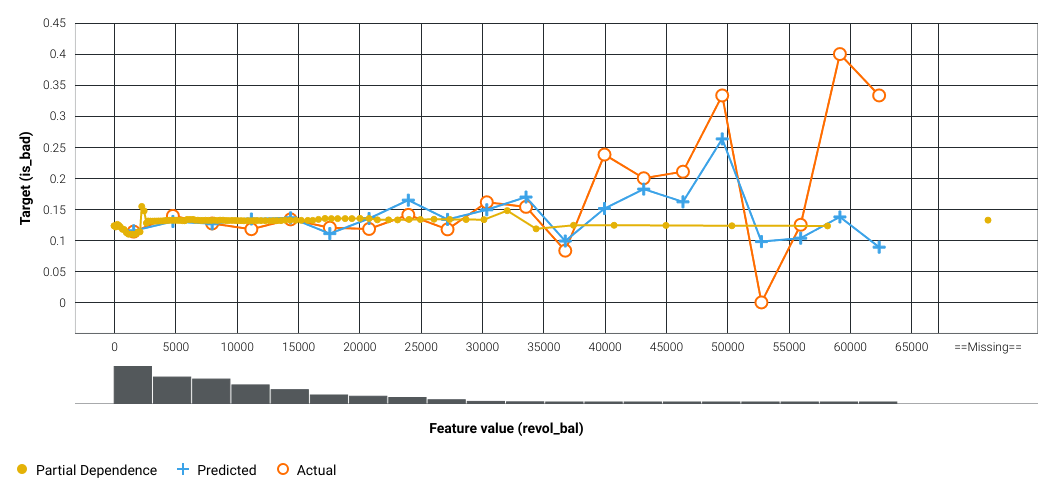
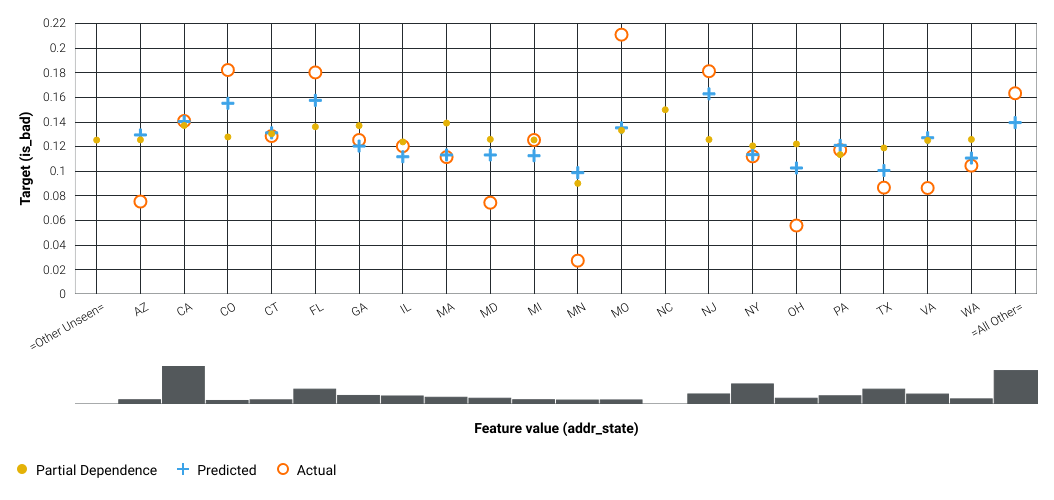
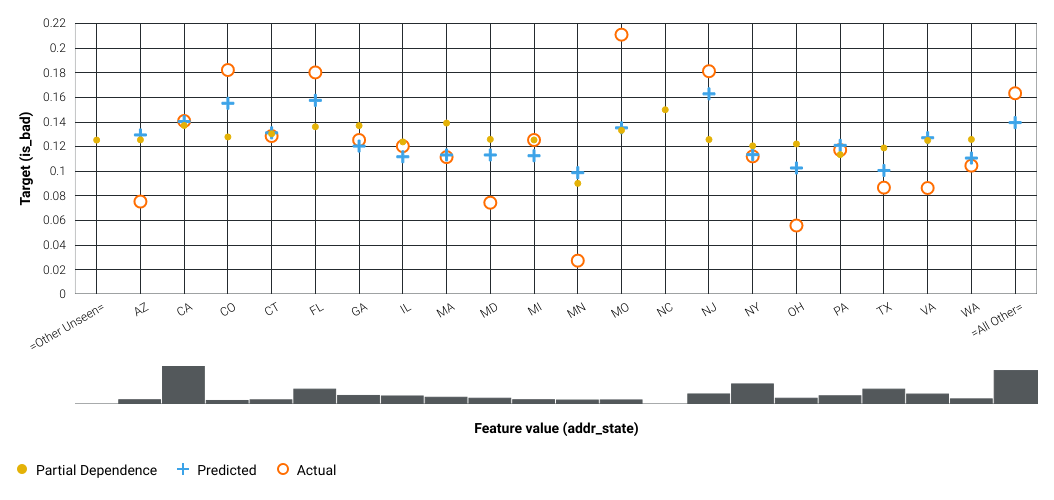
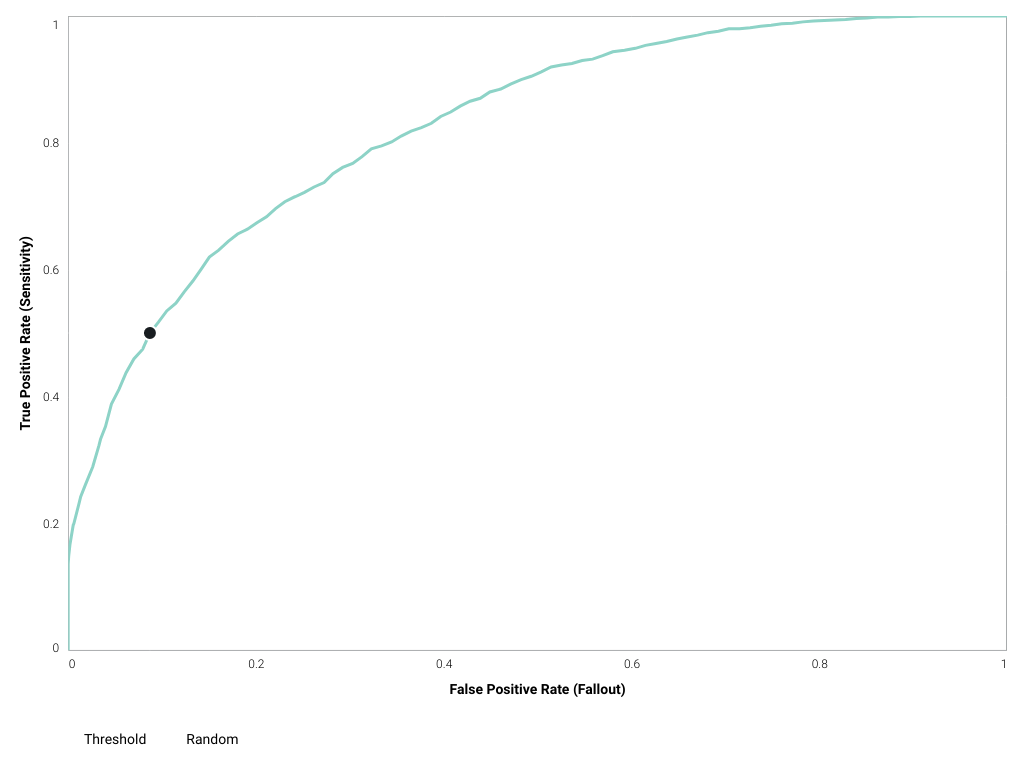
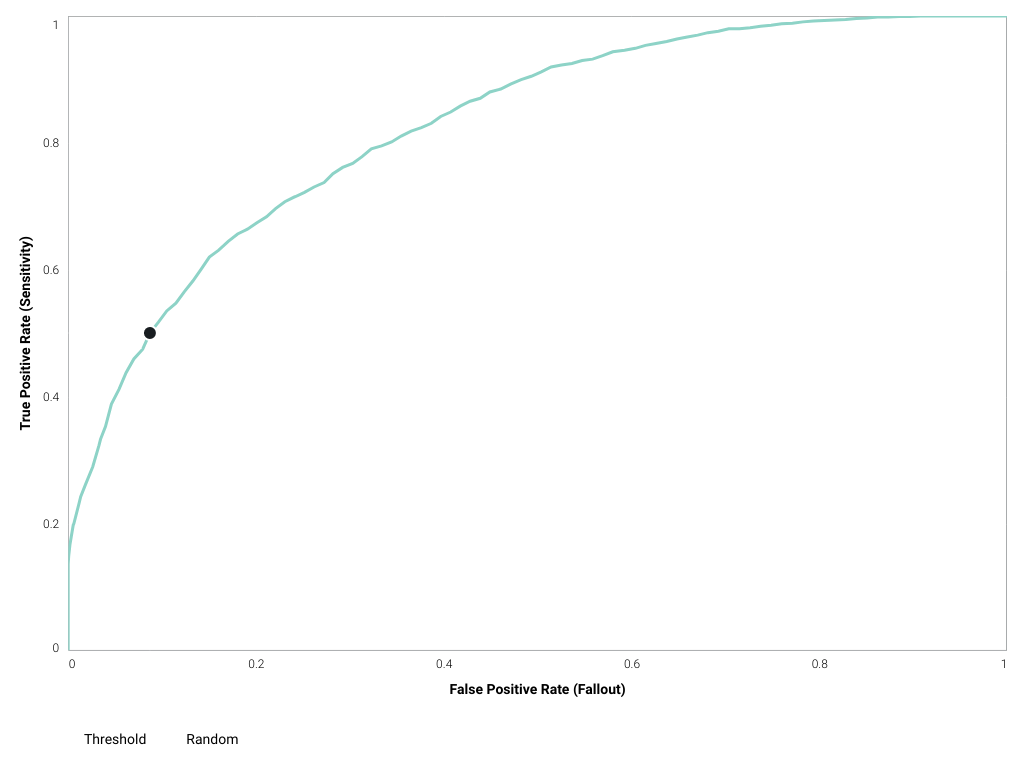
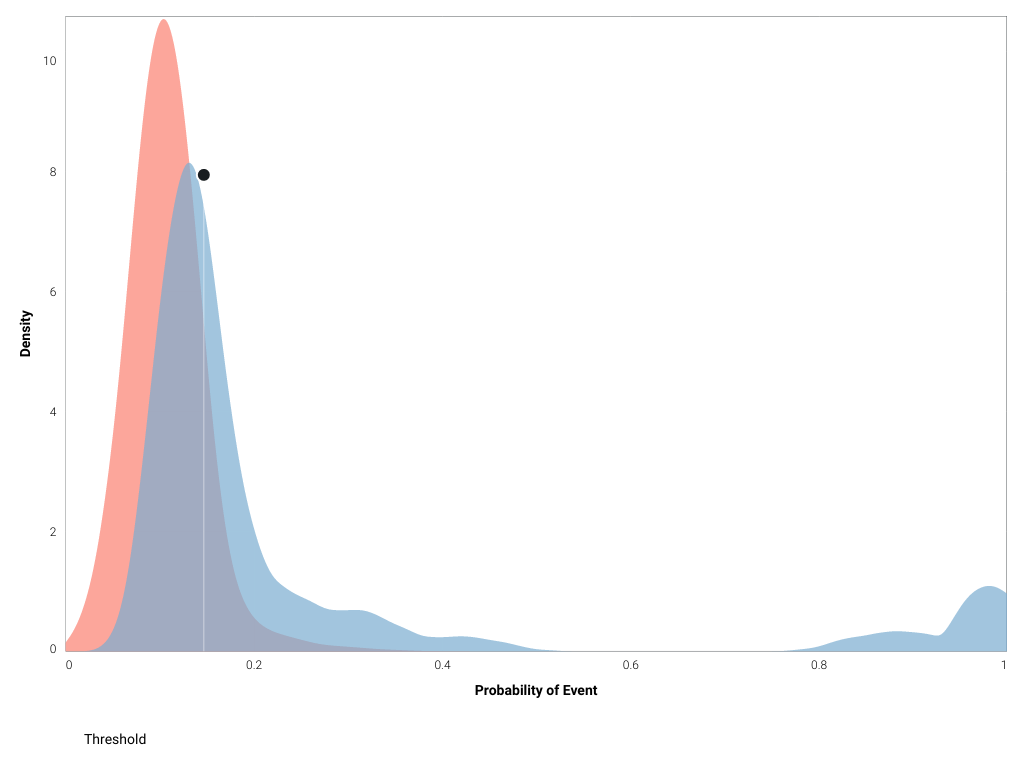
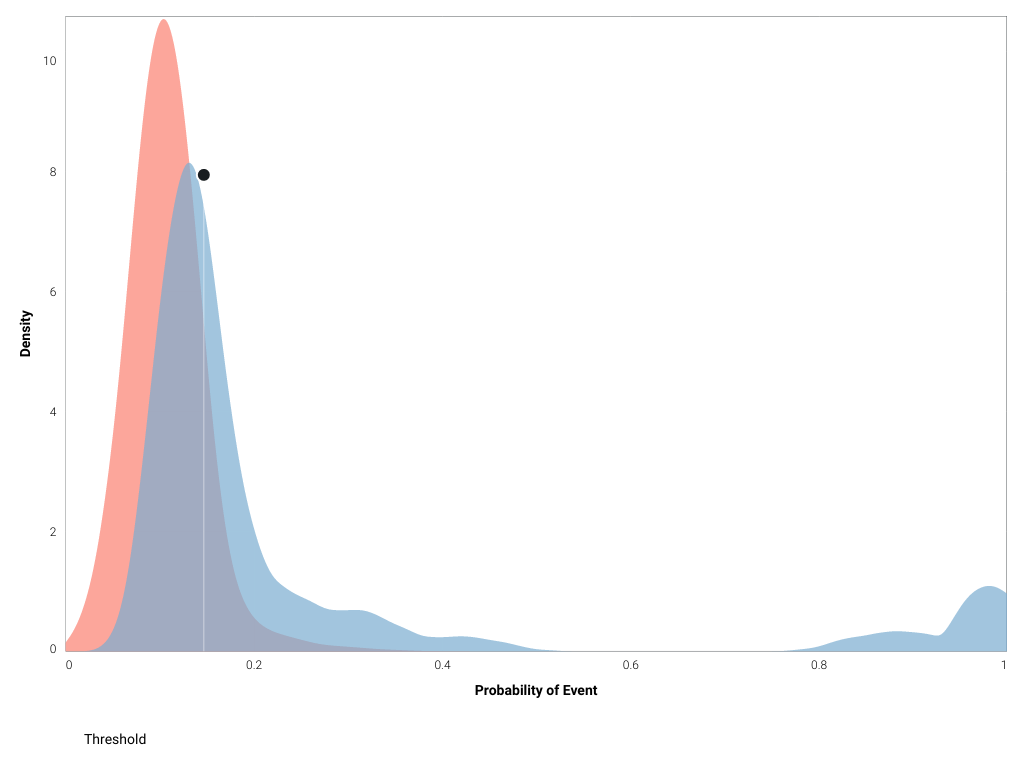

In [58]:
from IPython.display import HTML

with open("test.html", "r") as htmlfile:
    file_contents = htmlfile.read()

HTML(file_contents)

## Deploy a custom model

After successful testing, deploy the custom inference model to DataRobot’s dedicated prediction server.

In [ ]:
# Create new deployment
deployment = dr.Deployment.create_from_custom_model_version(
    custom_model_version_id=model_version.id,
    default_prediction_server_id=dr.PredictionServer.list()[1].id,
    label="Loan Default predictions - Custom Model Demo 2023-10-21",
    max_wait=600,
)

At any time while importing the custom inference model to DataRobot, you can use the DataRobot UI to monitor the process and veryify you are getting the expected outcomes. For example, the Custom Model Workshop for this custom inference model is shown below. From there, you can review that the custom model has been successfully tested and deployed. If necessary, you can generate and access the automated compliance report for this model.

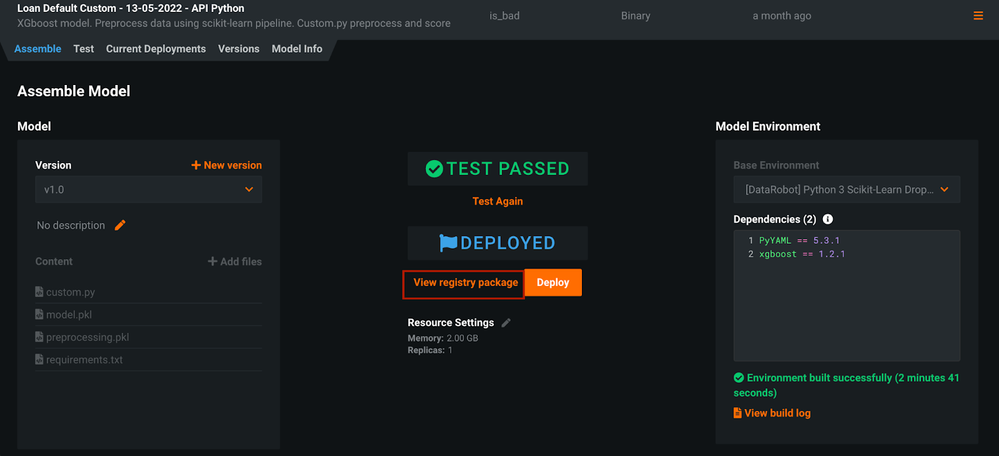

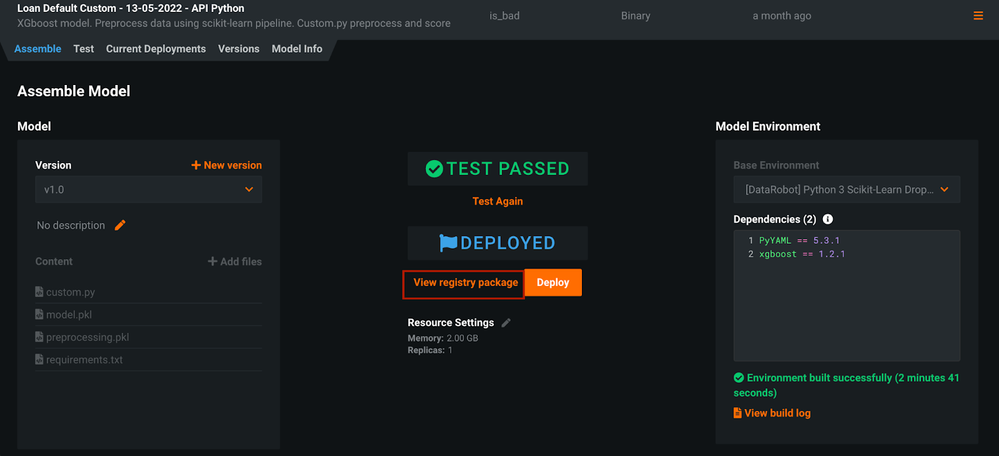

Additionally, you can browse the deployment from DataRobot’s deployment inventory. From there, you can start scoring the model and leveraging DataRobot's [model monitoring](https://docs.datarobot.com/en/docs/mlops/mlops-overview.html) capabilities.

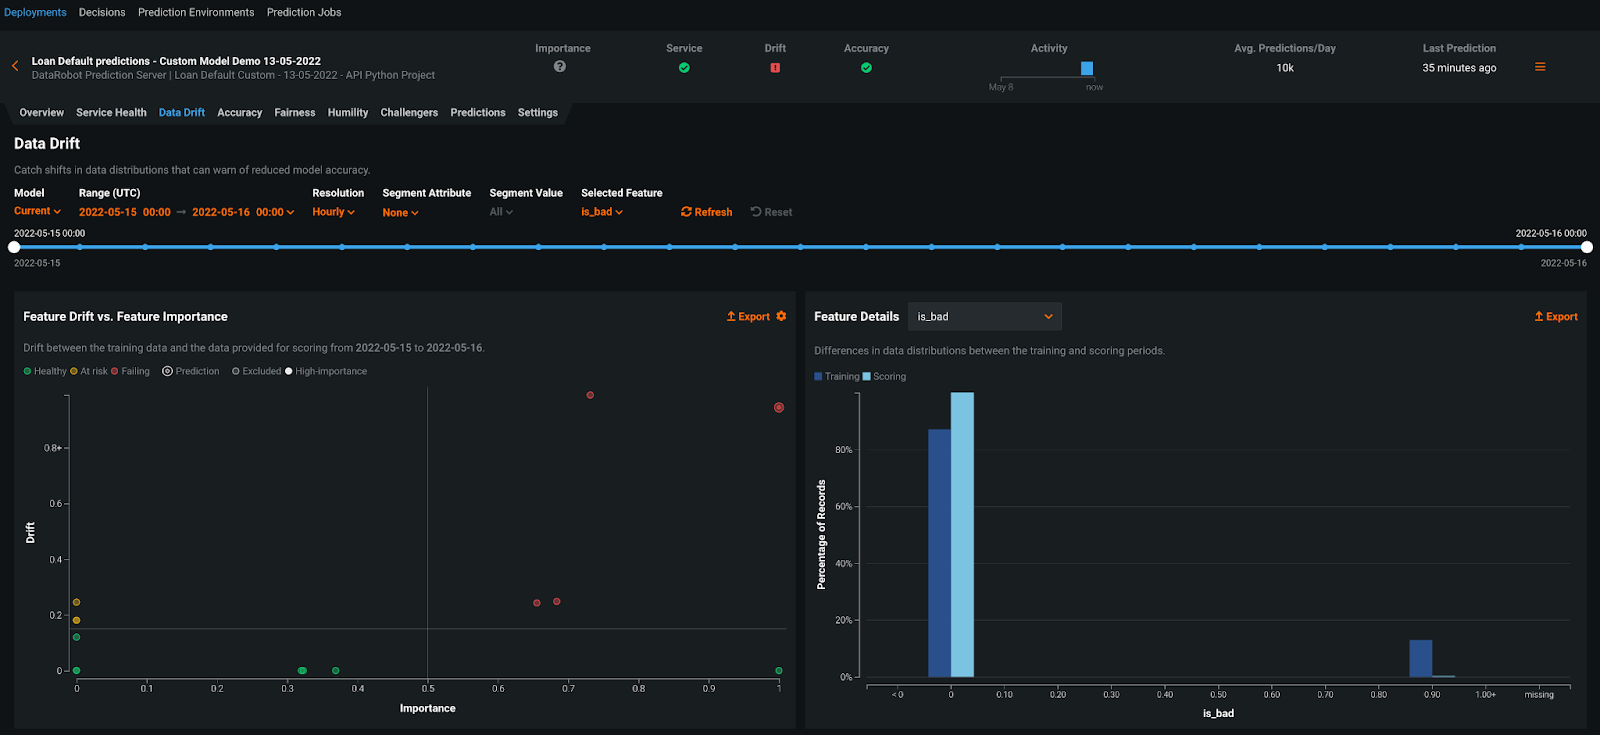